In [1]:
# this file will include the code, graphs and data selections relevant to the final report. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

sns.set_style("darkgrid")

In [2]:
def preprocessing_air_data(df):
    df['date_time']=pd.to_datetime(df['date_time'], origin='1899-12-30', unit='D')
    df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y')
    
    # Convert all non-numeric values (except dates) to NaN
    numeric_columns = df.columns[1:]  # All columns except the date column
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # # Convert negative values to 0
    # df[numeric_columns] = df[numeric_columns].clip(lower=0)

    # convert negative values to NaN
    df[numeric_columns] = df[numeric_columns].map(lambda x: np.nan if x < 0 else x)

    return df

In [3]:
def aggregate_half_monthly(df):
    """
    transform daily data to half-monthly data
    """
    
    # Calculate row means excluding NaN values
    # axis=1 means calculate across columns
    # skipna=True means ignore NaN values   
    df['half_month'] = df['date_time'].dt.day.apply(lambda x: 1 if x <= 15 else 2)
    
    df_downsampled = df.groupby([
        df['date_time'].dt.year.rename('year'),
        df['date_time'].dt.month.rename('month'),
        'half_month'
    ])[df.columns[1:-1]].mean().reset_index()

    # Create proper datetime for the downsampled data (using the 1st and 16th of each month)
    df_downsampled['date'] = pd.to_datetime(
        df_downsampled.apply(
            lambda x: f"{int(x['year'])}-{int(x['month'])}-{1 if x['half_month']==1 else 16}",
            axis=1
        ))

    df_downsampled = df_downsampled[["date", *df_downsampled.columns.difference(["date"])]]
    df_downsampled.drop(["year", "month", "half_month"], axis=1, inplace=True)
    return df_downsampled

In [4]:
# upload data and basic transformations
co_emission =  pd.read_csv('data/final_data.csv')
co_emission = preprocessing_air_data(co_emission)

## Missing Values Analysis

In this section we will aggregate and plot missing values over time. 

In [5]:
# aggregate missing values by year
co_emission_long = co_emission.melt(id_vars = ['date_time'], var_name = 'station', value_name='CO')

nan_by_year_station = co_emission_long.groupby([co_emission_long['date_time'].dt.year, 
                      'station'])['CO'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
nan_by_year_mean = nan_by_year_station.groupby("date_time")["NaN Count"].mean().reset_index(name = "NaN Count")


# aggregate missing values each month
nan_by_date = (
    co_emission_long.groupby([co_emission_long['date_time'].dt.year, co_emission_long['date_time'].dt.month, 'station'])['CO']
    .apply(lambda x: x.isna().sum())
    .rename_axis(['Year','Month', 'station'])
    .reset_index(name="NaN Count")
)
nan_by_date['date'] = pd.to_datetime(nan_by_date[['Year','Month']].assign(day=1))
nan_by_date.drop(["Year","Month"], axis=1, inplace=True)

nan_by_date_mean = (
  nan_by_date.groupby([nan_by_date['date'].dt.year, nan_by_date['date'].dt.month])['NaN Count']
 .mean()
 .rename_axis(['Year','Month'])
 .reset_index(name="NaN Count")
)
nan_by_date_mean['date'] = pd.to_datetime(nan_by_date_mean[['Year','Month']].assign(day=1))
nan_by_date_mean.drop(["Year","Month"], axis=1, inplace=True)

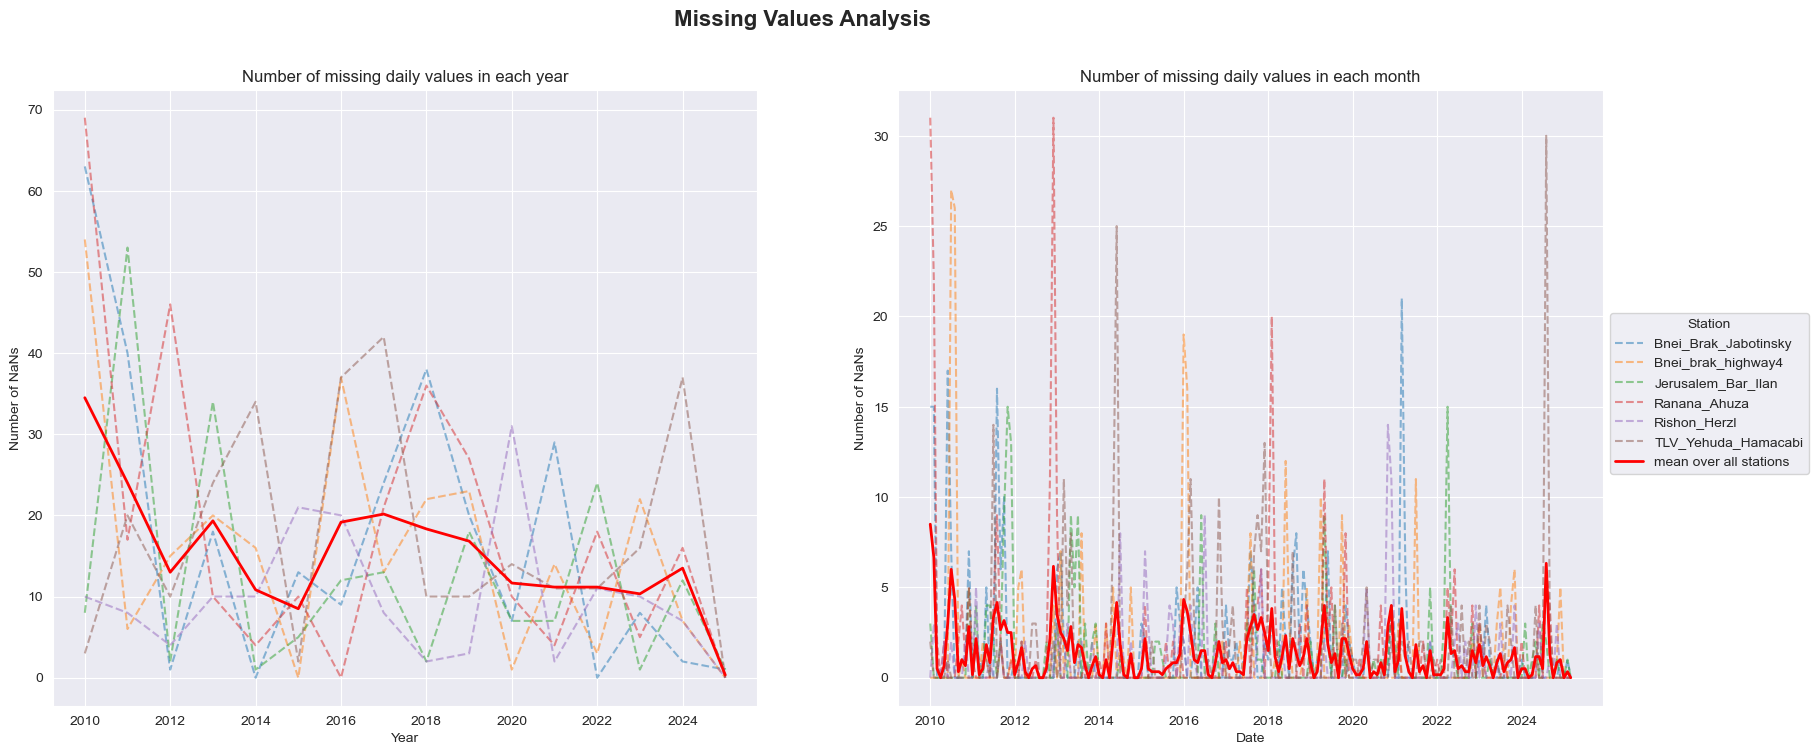

In [6]:
#plot both graphs

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.lineplot(ax = axes[0], data = nan_by_year_station, x='date_time', y='NaN Count', hue='station', alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[0], data = nan_by_year_mean, x = 'date_time', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of NaNs")
axes[0].set_title("Number of missing daily values in each year")

sns.lineplot(ax = axes[1], data = nan_by_date, x='date', y='NaN Count', hue='station',  alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[1], data = nan_by_date_mean, x='date', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of NaNs")
axes[1].set_title("Number of missing daily values in each month")

handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend_.remove()
axes[1].legend_.remove()
fig.legend(handles, labels, title="Station", loc="center left", bbox_to_anchor=(0.9, 0.5))

fig.suptitle("Missing Values Analysis", fontsize=16, fontweight="bold")
# plt.savefig("visualizations/missing_values_analysis.png", dpi=300, bbox_inches='tight')

plt.show()
 

## Seasonal Decomposition

In [5]:
co_half_monthly = aggregate_half_monthly(co_emission)
co_half_monthly_longer = co_half_monthly.melt(id_vars=['date'], var_name='station', value_name='CO')
co_half_monthly_longer.to_csv("data/co_half_monthly.csv", index=False)

In [6]:
def extract_decomposition(group, period_months, value_name='CO'):
    group = group.dropna(subset=[value_name])
    decomposition = seasonal_decompose(group[value_name], period=period_months, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    group['Residuals'] = decomposition.resid
    return group

In [7]:
co_decomposition = (
    co_half_monthly_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=24)
    .reset_index()
)
co_mean = co_decomposition.groupby(["date"])[["Observed","Trend", "Seasonal", "Residuals"]].mean().reset_index()

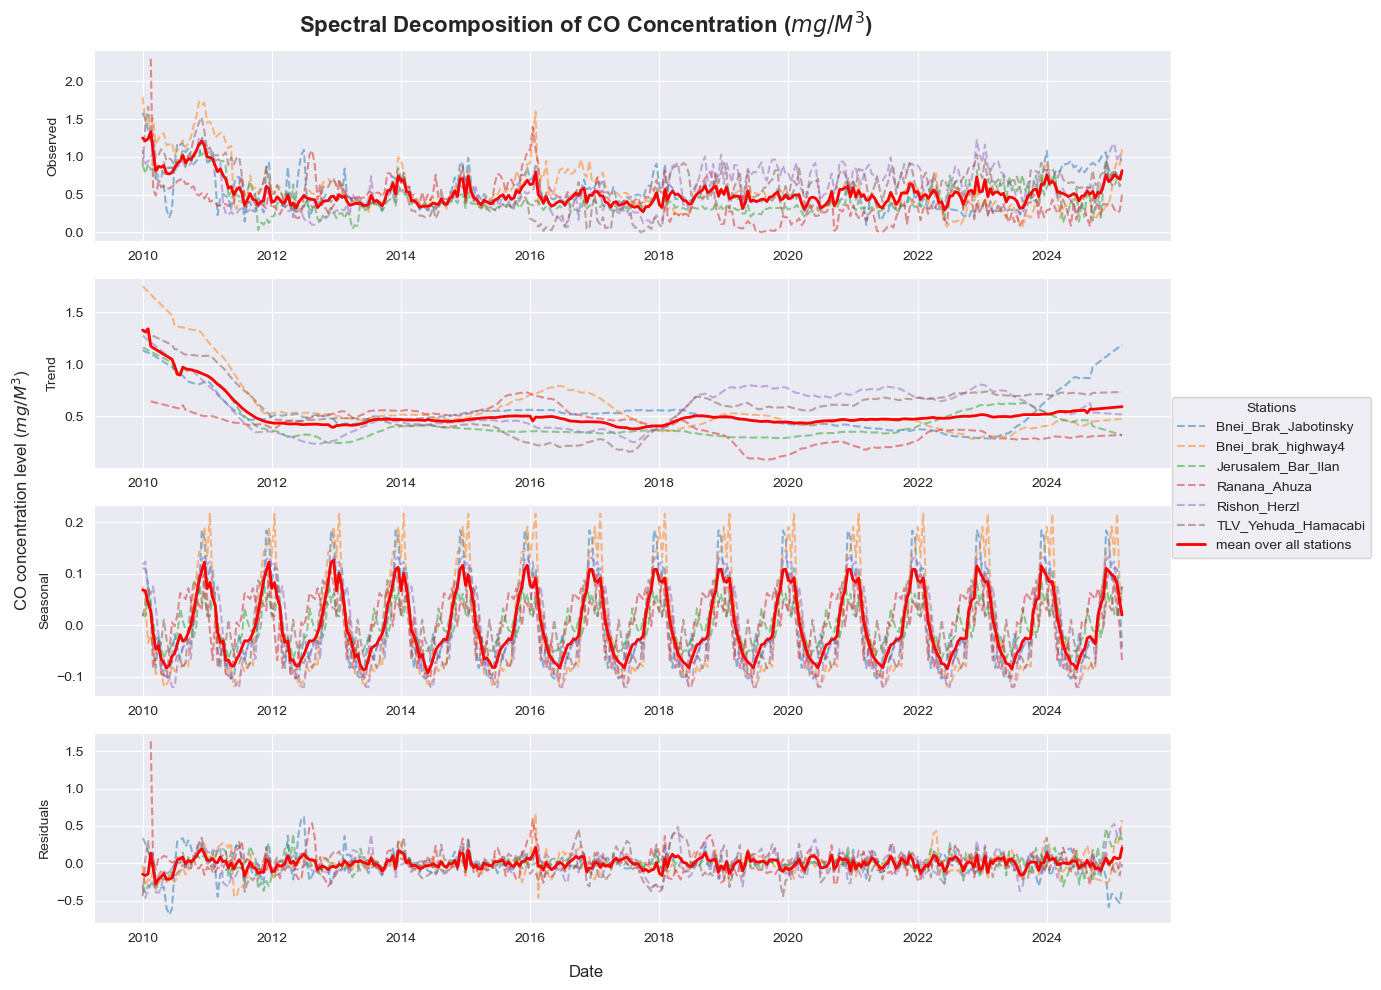

In [10]:
# plot spectral decomposition
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))

# observed
sns.lineplot(ax = axes[0], data = co_decomposition, x="date", y="Observed", hue = "station", alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[0], data = co_mean, x="date", y=r"Observed", color = "red", linewidth = 2, label="mean over all stations")

# trend
sns.lineplot(ax = axes[1], data = co_decomposition, x="date", y="Trend", hue = "station", alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[1], data = co_mean, x="date", y="Trend", color = "red", linewidth = 2, label="mean over all stations")

# seasonal component
sns.lineplot(ax = axes[2], data = co_decomposition, x="date", y="Seasonal", hue = "station", alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[2], data = co_mean, x="date", y="Seasonal", color = "red", linewidth = 2, label="mean over all stations")
# residuals
sns.lineplot(ax = axes[3], data = co_decomposition, x="date", y="Residuals", hue = "station", alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[3], data = co_mean, x="date", y="Residuals", color = "red", linewidth = 2, label="mean over all stations")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = "Stations", bbox_to_anchor=(1.16, 0.60))

for ax in axes:
    ax.legend_.remove()
    ax.set_xlabel("")

fig.suptitle(r"Spectral Decomposition of CO Concentration ($mg/M^3$)", fontsize=16, fontweight="bold")
fig.supylabel(r"CO concentration level ($mg/M^3$)")
fig.supxlabel("Date")

plt.tight_layout()
#plt.savefig("visualizations/spectral_decomposition_final.png", dpi=300, bbox_inches='tight')
plt.show()

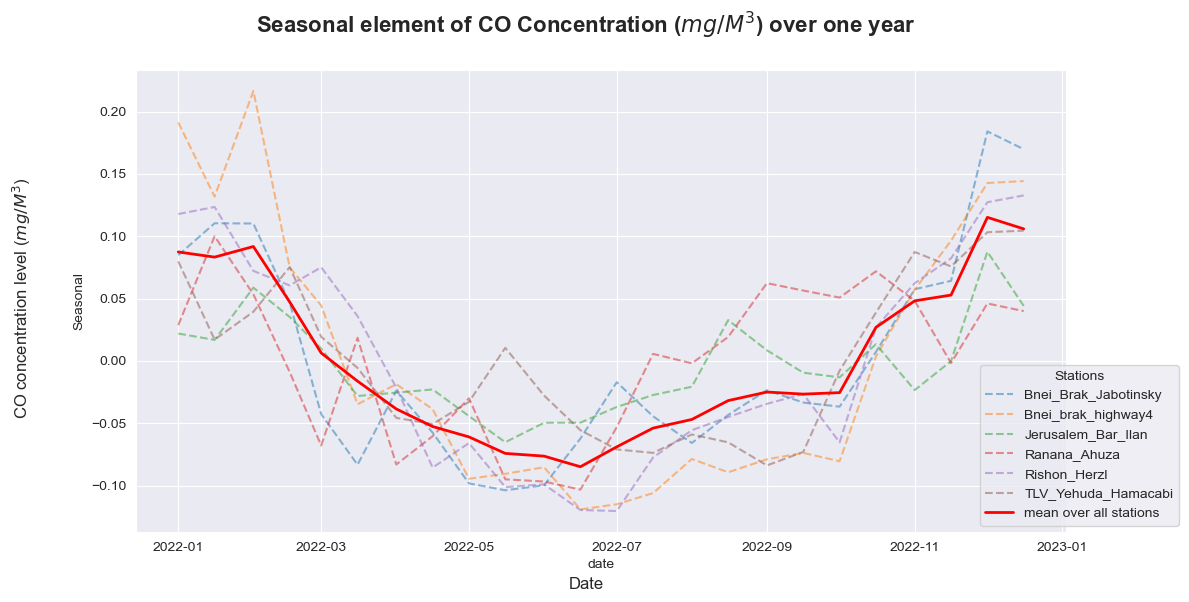

In [24]:
# plot Seasonal element for one year to demonstrate noise
selected_year = 2022
decomposition_one_year = co_decomposition[co_decomposition.date.dt.year == selected_year]
decomposition_mean_one_year = co_mean[co_mean.date.dt.year == selected_year]

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(ax = ax1, data = decomposition_one_year, x="date", y="Seasonal", hue = "station", alpha = 0.5, linestyle='--')
sns.lineplot(ax = ax1, data = decomposition_mean_one_year, x="date", y="Seasonal", color = "red", linewidth = 2, label="mean over all stations")
ax1.legend_.remove()
fig.suptitle(r"Seasonal element of CO Concentration ($mg/M^3$) over one year", fontsize=16, fontweight="bold")
fig.supylabel(r"CO concentration level ($mg/M^3$)")
fig.supxlabel("Date")
fig.legend(title = "Stations", bbox_to_anchor=(1, 0.4))
# plt.savefig("visualizations/seasonal_one_year.png", dpi=300, bbox_inches='tight') 
plt.show()